<h3><B>conda environment:</b> pertpy_deg_env, python v3.11.11

In [1]:
import warnings

import decoupler as dc
import pertpy as pt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from adjustText import adjust_text
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

from filter_adata import adata_filtered, adata_peritumour, adata_hightumour

from pathlib import Path
home_path = '/Users/nabilazulkapeli/Documents/Honours Thesis 2025/nabs_data'
home_path = Path(home_path)
DEG_path = home_path / f'DEG_figures'
DEG_path.mkdir(parents=True, exist_ok=True)
DEG_path = Path(DEG_path)

sns.set_theme(context='paper', style='ticks',font='sans-serif')

/opt/anaconda3/envs/pertpy_deg_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


adata and clinical merged, rename the columns if you want
clusters are now annotated with specific and broad cell types
low quality cores with <1000 total cells or <100 melanoma cells have been removed
adata_filtered (both high tumour and peritumour cores) has been created
adata_hightumour (only high tumour cores) has been created
adata_peritumour (only peritumour cores) has been created
ready for downstream analysis, you can choose adata_filtered for global analysis and adata_peritumour/adata_hightumour for region-specific analyses


In [ ]:
# dictionaries for plots

simple_dict = {
    "CD8 T": "Immune",
    "CD4 T": "Immune",
    "Plasma": "Immune",
    "Plasmablast": "Immune",
    "TLS": "Immune",
    "Dendritic": "Immune",
    "Granulocyte": "Immune",
    "M1 TAM": "Immune",
    "M2 TAM": "Immune",
    "Ig-TAM": "Immune",
    "iCAF": "Stromal",
    "cCAF": "Stromal",
    "Endothelial": "Stromal",
    "Epithelial": "Stromal",
    "Melanoma": "Tumour",
    "Mast": "Immune"
}

response_palette = {"Responder": "#66c2a5", "Non-Responder": "#fc8d62"}

response_order = [
    "Responder",
    "Non-Responder"
]

new_labels_colors = {
    "Melanoma": "#b0b0b0",
    "Endothelial": "#7C3C67",
    "Epithelial": "#AF5A93",
    "cCAF": "#BD75A5",
    "iCAF": "#CA91B7",
    "Mast": "#4B3D80",
    "Granulocyte": "#67589B",
    "Dendritic": "#264566",
    "M1 TAM": "#496F97",
    "M2 TAM": "#5B83AE",
    "Ig-TAM": "#7697BC",
    "Plasmablast": "#3E7682",
    "Plasma": "#4D99A8",
    "TLS": "#65AAB8",
    "CD4 T": "#81BAC5",
    "CD8 T": "#ABD1D8"
}

core_order = [
'High Tumour: 0040207_Region_4_14-D'
 'High Tumour: 0029039_Region_1_4-C'
 'High Tumour: 0029039_Region_1_4-E'
 'High Tumour: 0029039_Region_1_5-A'
 'High Tumour: 0029039_Region_1_5-C'
 'High Tumour: 0029039_Region_1_5-E'
 'High Tumour: 0029039_Region_1_6-A'
 'High Tumour: 0029039_Region_1_6-C'
 'High Tumour: 0029039_Region_1_6-E'
 'High Tumour: 0029039_Region_2_10-E'
 'High Tumour: 0029039_Region_2_11-E'
 'High Tumour: 0029039_Region_2_7-C'
 'High Tumour: 0029039_Region_2_7-E'
 'High Tumour: 0029039_Region_2_8-E'
 'High Tumour: 0029039_Region_2_9-E'
 'High Tumour: 0029039_Region_3_10-A'
 'High Tumour: 0029039_Region_3_10-C'
 'High Tumour: 0029039_Region_3_11-A'
 'High Tumour: 0029039_Region_3_7-A'
 'High Tumour: 0029039_Region_3_8-A'
 'High Tumour: 0029039_Region_3_8-C'
 'High Tumour: 0029039_Region_3_9-A'
 'High Tumour: 0029039_Region_3_9-C'
 'High Tumour: 0040207_Region_4_14-A'
 'High Tumour: 0040207_Region_4_14-B'
 'High Tumour: 0040207_Region_4_14-C'
 'Peritumour: 0029039_Region_1_4-B'
 'Peritumour: 0029039_Region_1_4-D'
 'Peritumour: 0029039_Region_1_4-F'
 'Peritumour: 0029039_Region_1_5-B'
 'Peritumour: 0029039_Region_1_6-B'
 'Peritumour: 0029039_Region_1_6-D'
 'Peritumour: 0029039_Region_1_6-F'
 'Peritumour: 0029039_Region_2_10-D'
 'Peritumour: 0029039_Region_2_7-F'
 'Peritumour: 0029039_Region_2_8-F'
 'Peritumour: 0029039_Region_2_9-D'
 'Peritumour: 0029039_Region_2_9-F'
 'Peritumour: 0029039_Region_3_10-B'
 'Peritumour: 0029039_Region_3_11-B'
 'Peritumour: 0029039_Region_3_7-B'
 'Peritumour: 0029039_Region_3_8-B'
 'Peritumour: 0029039_Region_3_9-B'
 'Peritumour: 0052306_Region_4_14-A'
 'Peritumour: 0052306_Region_4_14-D'
]

# custom R vs NR colourmap
colors = ["#fc8d62", "white", "#66c2a5"]
nodes = [0.0, 0.5, 1.0] # Anchor points in the range [0, 1]
response_diverging = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

<h1><b>Pseudobulking

In [ ]:
pdata = dc.pp.pseudobulk(adata_filtered, sample_col="Melpin", groups_col="new_specific_labels", layer="counts", mode="sum")
dc.pp.filter_samples(pdata, inplace=True)
pdata

AnnData object with n_obs × n_vars = 376 × 480
    obs: 'Melpin', 'new_specific_labels', 'response', 'total_counts_mt', 'pct_counts_mt', 'doublet_predictions', '_scvi_batch', 'DOB', 'Trial ', 'Treatment Start Date', 'Drug given', 'Drug simplified', 'Baseline tissue collected on', 'Accession Number', 'Block', 'Sample Timepoint', 'Site of Biopsy', 'Site of Biopsy (Simplified)', 'Comment- Ella Study', 'Best response reached', 'Response_RECIST', 'Progressed', 'Progressed date', 'Followup date', 'Progression-free survival', 'Overall Survival', 'Followup status', 'Response', 'Age at start of treatment', 'Sex', 'Baseline LDH (elevated/normal)', 'Mutation status', 'Mutation status (Simplified)', 'Prior BRAF/MEKi (Yes/No)', 'Prior IT (if yes which ones)', 'M stage at entry', 'Primary melanoma site', 'Cutaneous primary (Yes/No)', 'ECOG', 'Baseline blood date', 'Hemaglobin', 'Neutrophils', 'Lymphocytes', 'Brain metastasis (Yes/No)', 'Lung metastasis (Yes/No)', 'Liver metastasis (Yes/No)', 'specif

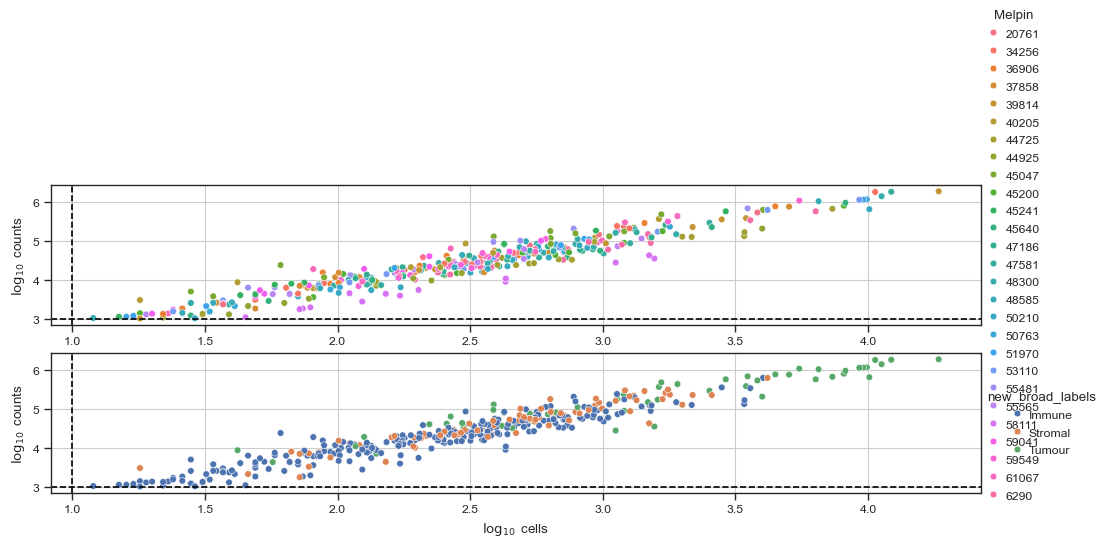

In [15]:
dc.pl.filter_samples(pdata, groupby=["Melpin", "new_broad_labels"], figsize=(12, 4))

In [16]:
pdata.layers["counts"] = pdata.X.copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.pp.pca(pdata)

In [ ]:
# return raw counts to X
dc.pp.swap_layer(pdata, "counts", inplace=True)

In [19]:
pdata

AnnData object with n_obs × n_vars = 376 × 480
    obs: 'Melpin', 'new_specific_labels', 'response', 'total_counts_mt', 'pct_counts_mt', 'doublet_predictions', '_scvi_batch', 'DOB', 'Trial ', 'Treatment Start Date', 'Drug given', 'Drug simplified', 'Baseline tissue collected on', 'Accession Number', 'Block', 'Sample Timepoint', 'Site of Biopsy', 'Site of Biopsy (Simplified)', 'Comment- Ella Study', 'Best response reached', 'Response_RECIST', 'Progressed', 'Progressed date', 'Followup date', 'Progression-free survival', 'Overall Survival', 'Followup status', 'Response', 'Age at start of treatment', 'Sex', 'Baseline LDH (elevated/normal)', 'Mutation status', 'Mutation status (Simplified)', 'Prior BRAF/MEKi (Yes/No)', 'Prior IT (if yes which ones)', 'M stage at entry', 'Primary melanoma site', 'Cutaneous primary (Yes/No)', 'ECOG', 'Baseline blood date', 'Hemaglobin', 'Neutrophils', 'Lymphocytes', 'Brain metastasis (Yes/No)', 'Lung metastasis (Yes/No)', 'Liver metastasis (Yes/No)', 'specif

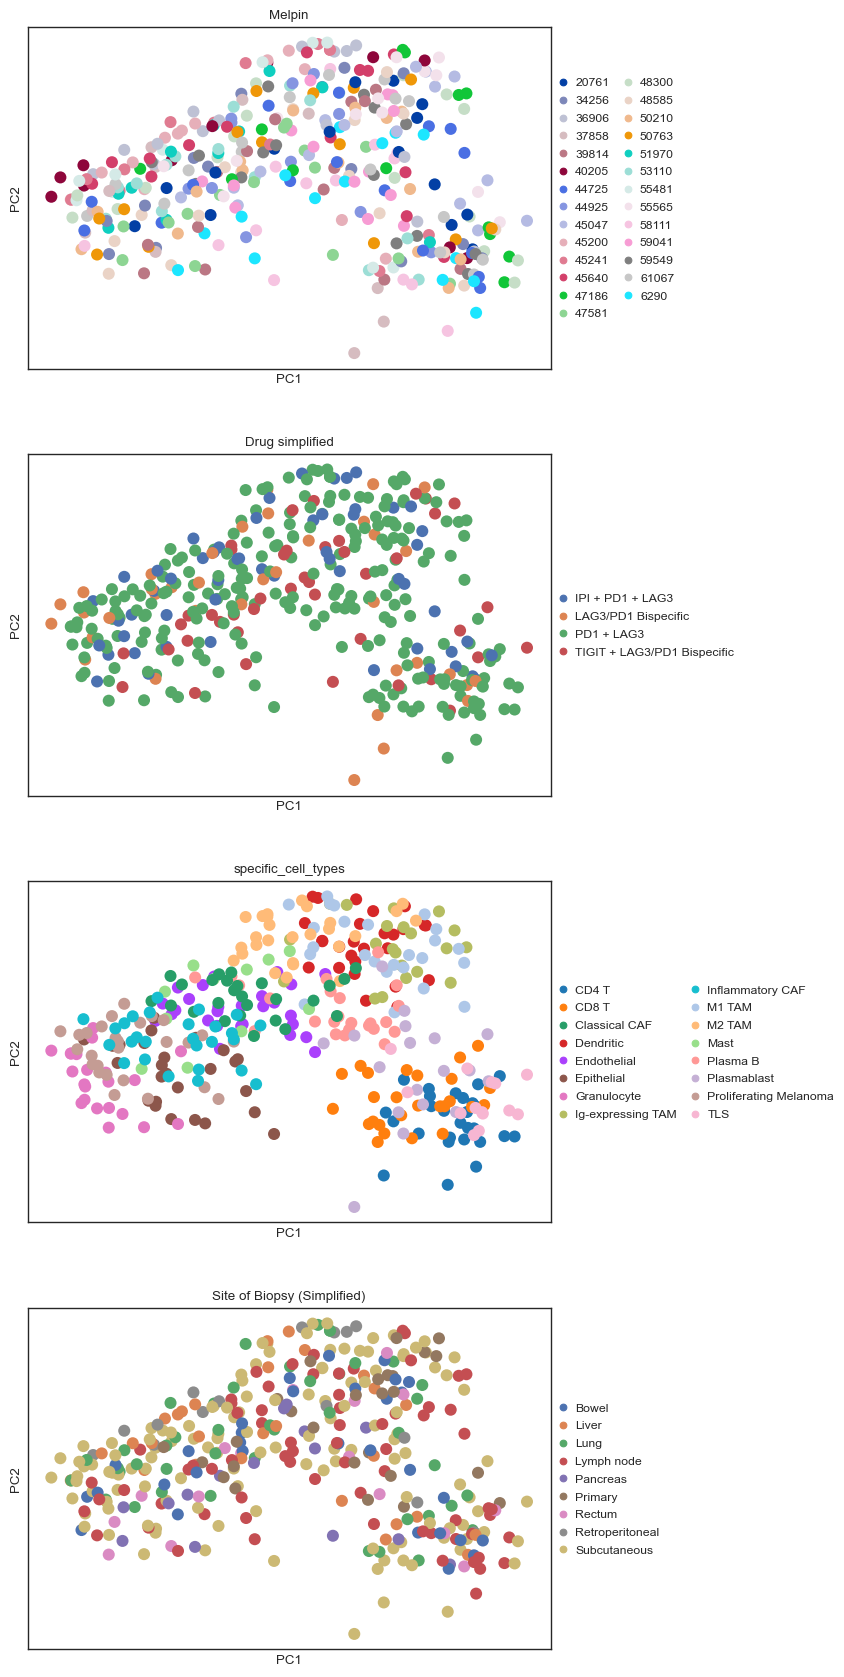

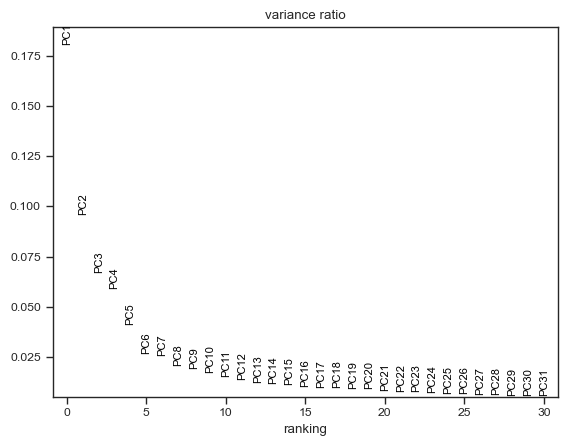

In [20]:
sc.pl.pca(pdata, color=["Melpin", "Drug simplified", "specific_cell_types", "Site of Biopsy (Simplified)"], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

<h1><b>Global DEG Analysis

In [21]:
pds2 = pt.tl.PyDESeq2(adata=pdata, design="~Response")

In [22]:
pds2.fit()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.11 seconds.

Fitting dispersion trend curve...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 46 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [23]:
res_df = pds2.test_contrasts(pds2.contrast(column="Response", baseline="Non-Responder", group_to_compare="Responder"))
res_df.head(10)

Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_id                                                                   
NOTCH3      49.338652        0.572157  0.232031  2.465862  1.366839e-02   
HLA-B      357.457151        1.032677  0.126086  8.190268  2.606446e-16   
IL4          1.099709       -1.058841  0.216664 -4.887015  1.023764e-06   
AREG         4.428102       -0.645419  0.255425 -2.526846  1.150919e-02   
CTSW         9.072422        1.000053  0.247953  4.033230  5.501542e-05   
...               ...             ...       ...       ...           ...   
TNFRSF13C   20.460192        0.143854  0.219952  0.654024  5.130966e-01   
CLEC14A     15.424897        0.548312  0.311139  1.762275  7.802286e-02   
CD79A       14.984391        1.042320  0.306725  3.398220  6.782589e-04   
IFI35       40.452013        0.695198  0.091252  7.618481  2.566775e-14   
VEGFA       96.294144       -0.573542

Running Wald tests...
... done in 0.08 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,EPCAM,4.536053,-2.605649,0.196984,-13.227724,6.069794e-40,2.913501e-37,None
1,PDGFRA,70.939915,-2.821102,0.257837,-10.941399,7.306391e-28,1.753534e-25,None
2,CCL16,6.124549,-2.078017,0.220379,-9.429278,4.129233e-21,5.466000e-19,None
3,SLC7A11,22.819265,-2.471789,0.262426,-9.418978,4.555000e-21,5.466000e-19,None
4,SLC1A5,200.128127,-1.428038,0.167143,-8.543795,1.298838e-17,1.246885e-15,None
5,PSMB9,45.714468,1.065841,0.128269,8.309445,9.615064e-17,7.692052e-15,None
6,HLA-B,357.457151,1.032677,0.126086,8.190268,2.606446e-16,1.687328e-14,None
7,CFC1,4.708677,-1.721620,0.210438,-8.181118,2.812213e-16,1.687328e-14,None
8,CCND1,583.171203,-1.252331,0.155788,-8.038688,9.080575e-16,4.842973e-14,None
9,MX1,91.150230,1.369274,0.172686,7.929295,2.203934e-15,1.057888e-13,None


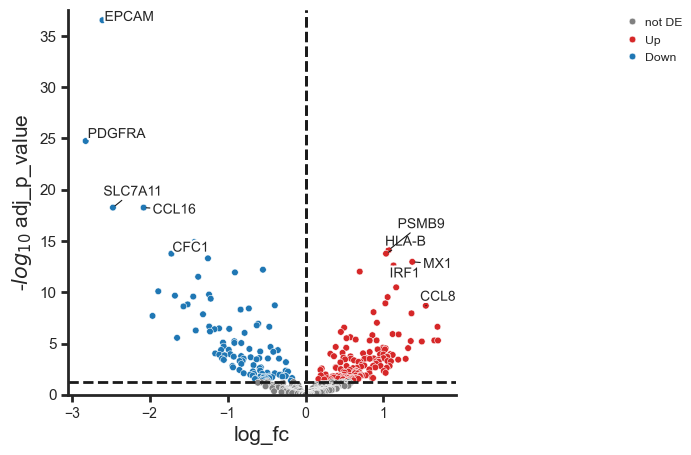

In [24]:
pds2.plot_volcano(res_df, log2fc_thresh=0)

2025-10-29 17:34:41 | [INFO] maxp pruned
2025-10-29 17:34:41 | [INFO] LTSH dropped
2025-10-29 17:34:41 | [INFO] cmap pruned
2025-10-29 17:34:41 | [INFO] kern dropped
2025-10-29 17:34:41 | [INFO] post pruned
2025-10-29 17:34:41 | [INFO] PCLT dropped
2025-10-29 17:34:41 | [INFO] JSTF dropped
2025-10-29 17:34:41 | [INFO] DSIG dropped
2025-10-29 17:34:41 | [INFO] GPOS pruned
2025-10-29 17:34:41 | [INFO] GSUB pruned
2025-10-29 17:34:41 | [INFO] glyf pruned
2025-10-29 17:34:41 | [INFO] Added gid0 to subset
2025-10-29 17:34:41 | [INFO] Added first four glyphs to subset
2025-10-29 17:34:41 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-10-29 17:34:41 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'X', 'Y', 'eight', 'five', 'hyphen', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'two']
2025-10-29 17:34:41 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 24, 25, 26, 27, 28, 36, 37, 3

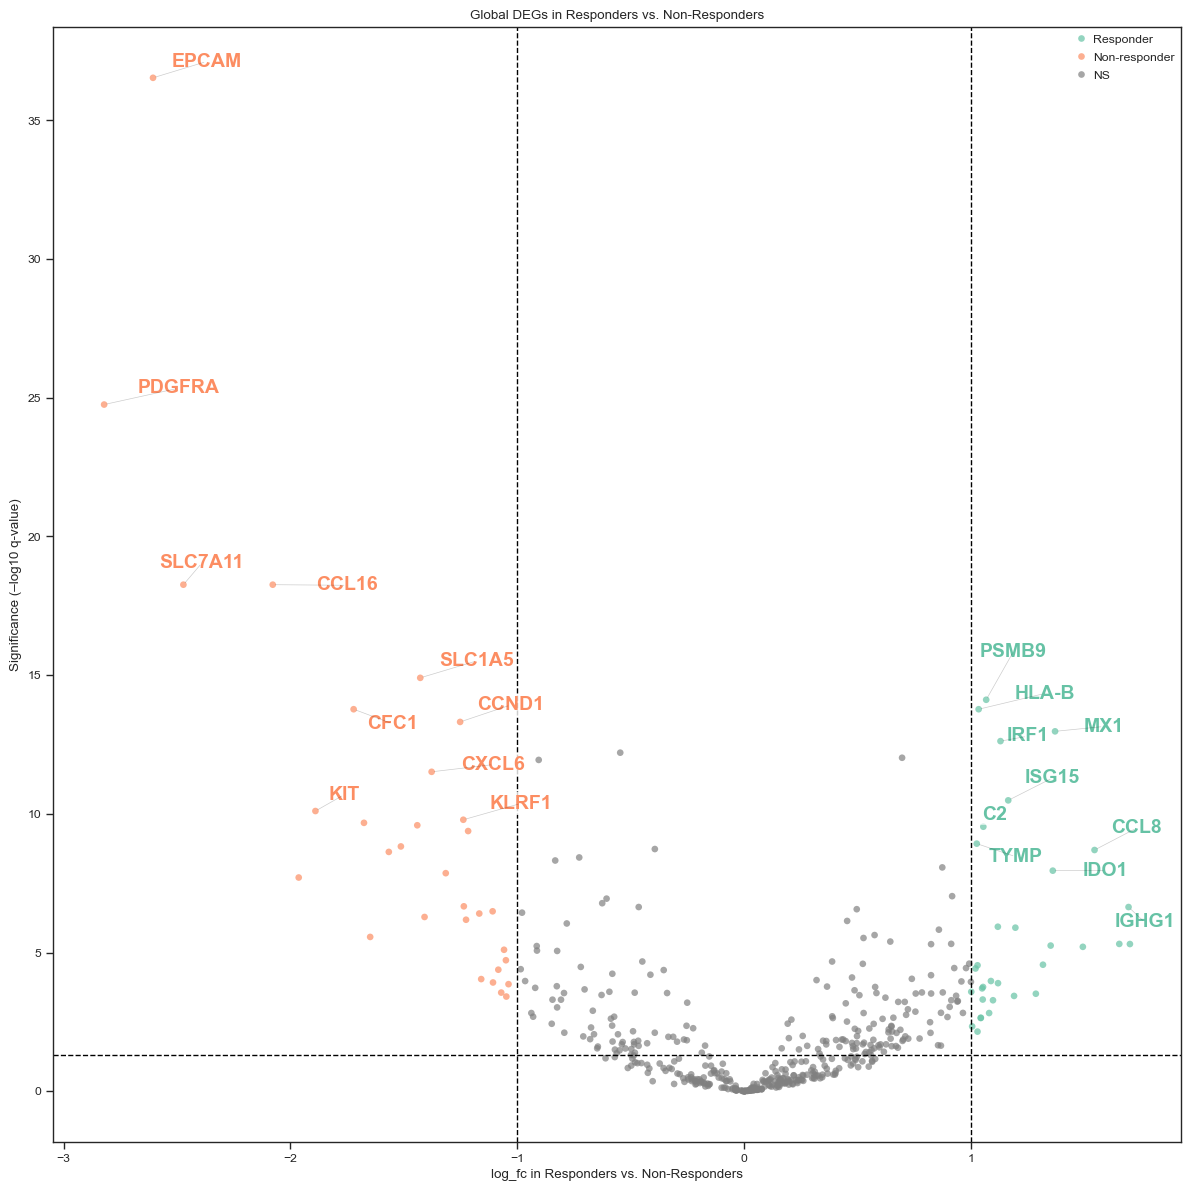

In [ ]:
# first, extract q-values and lfc from dataframe:
df = res_df.copy()
df.replace(0.0, 1e-323)

# set thresholds
adj_p_value_max = 0.05            # q-value < 0.05
lfc_min = 1                       # lfc < 1

df['-log10(adj_p_value)'] = -np.log10(df['adj_p_value'])  # -log10(q) so a smaller (more significant) q-values have points higher on the y-axis

def label(row):
    if row['adj_p_value'] < adj_p_value_max and row['log_fc'] > lfc_min:
        return 'Responder'
    elif row['adj_p_value'] < adj_p_value_max and row['log_fc'] < -lfc_min:
        return 'Non-responder'
    else:
        return 'NS'
df['enriched_in'] = df.apply(label, axis=1)

lfc_cap = 20 
df["log_fc_capped"] = df["log_fc"].clip(-lfc_cap, lfc_cap)

# volcano plot
plt.figure(figsize=(12,12))
sns.scatterplot(
    data=df, x="log_fc_capped", y="-log10(adj_p_value)",
    hue="enriched_in", hue_order=["Responder", "Non-responder", "NS"],
    palette={"Responder":"#66c2a5", "Non-responder":"#fc8d62", "NS":"grey"},
    alpha=0.7, edgecolor="none"
)

# logfc and qval threshold lines
plt.axhline(-np.log10(adj_p_value_max), color="black", linestyle="--", linewidth=1)
plt.axvline(lfc_min, color="black", linestyle="--", linewidth=1)
plt.axvline(-lfc_min, color="black", linestyle="--", linewidth=1)

# top 10 DEGs in R and NR
top_responder = df[
    (df['enriched_in'] == "Responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)
top_nonresponder = df[
    (df['enriched_in'] == "Non-responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)

# label top 10 DEGs
texts = []
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#66c2a5",  # same color as responders
        ha='left', va='baseline',
        weight='bold',
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
    )
    for _, row in top_responder.iterrows()
)
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#fc8d62",  # same color as non-responders
        weight='bold',
        ha='left', va='baseline',
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=1.5)
    )
    for _, row in top_nonresponder.iterrows()
)
# adjust labels to avoid overlaps
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5, alpha=0.2),
            force_points=3.5, expand=(1.5, 1.5))

plt.xlabel("log_fc in Responders vs. Non-Responders")
plt.ylabel("Significance (–log10 q-value)")
plt.title("Global DEGs in Responders vs. Non-Responders")
plt.legend()
plt.tight_layout()
plt.savefig(DEG_path / 'global_volcano.pdf', bbox_inches='tight', dpi=300)
plt.show()

2025-10-29 17:34:47 | [INFO] maxp pruned
2025-10-29 17:34:47 | [INFO] LTSH dropped
2025-10-29 17:34:47 | [INFO] cmap pruned
2025-10-29 17:34:47 | [INFO] kern dropped
2025-10-29 17:34:47 | [INFO] post pruned
2025-10-29 17:34:47 | [INFO] PCLT dropped
2025-10-29 17:34:47 | [INFO] JSTF dropped
2025-10-29 17:34:47 | [INFO] DSIG dropped
2025-10-29 17:34:47 | [INFO] GPOS pruned
2025-10-29 17:34:47 | [INFO] GSUB pruned
2025-10-29 17:34:47 | [INFO] glyf pruned
2025-10-29 17:34:47 | [INFO] Added gid0 to subset
2025-10-29 17:34:47 | [INFO] Added first four glyphs to subset
2025-10-29 17:34:47 | [INFO] Closing glyph list over 'GSUB': 53 glyphs before
2025-10-29 17:34:47 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'space',

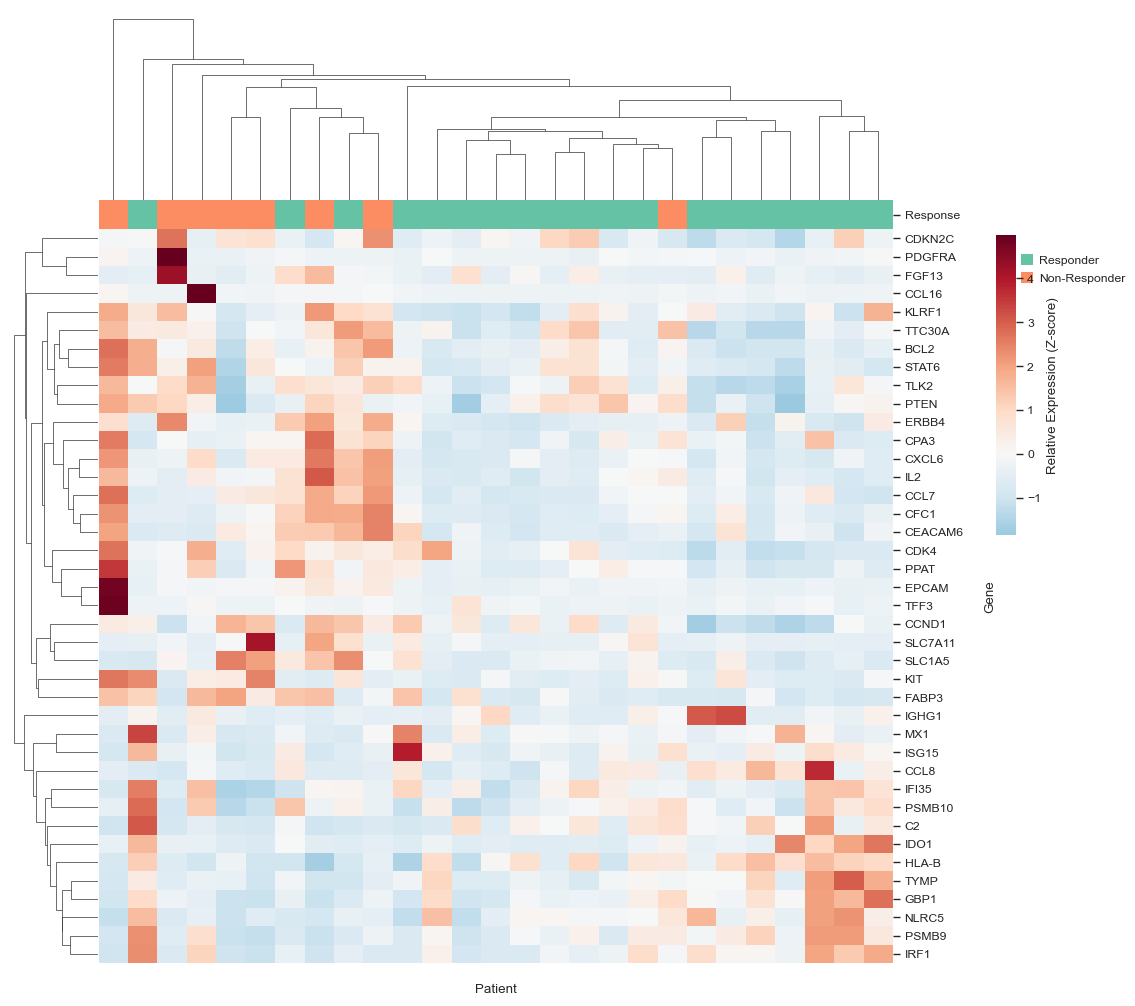

In [ ]:
# global z-scored clustermap
df = res_df.copy()
df.replace(0.0, 1e-323)

# top 40 DEGs by q-value (adjusted p-val)
global_top_genes = df.sort_values("adj_p_value").drop_duplicates("variable").head(40)["variable"]

# subset expression data (genes × samples)
exp_matrix = adata_filtered[:, global_top_genes].to_df()
exp_matrix["Patient"] = adata_filtered.obs["Melpin"].values     # aggregate by patient ID
exp_matrix_avg = exp_matrix.groupby("Patient").mean().T  

# z-score transform each gene
exp_matrix_z = exp_matrix_avg.apply(
    lambda x: (x - x.mean()) / x.std(), axis=1
)

# add in patient metadata
meta = adata_filtered.obs.drop_duplicates("Melpin").set_index("Melpin")
meta = meta.loc[exp_matrix_avg.columns]  # align with patient order

# map the R v NR colours
response_palette = {"Responder": "#66c2a5", "Non-Responder": "#fc8d62"}
col_colors = pd.DataFrame({
    "Response": meta["Response"].map(response_palette)
})

# clustered heatmap
g = sns.clustermap(
    exp_matrix_z,
    cmap="RdBu_r",
    center=0,
    col_colors=col_colors,
    figsize=(10, 10),
    xticklabels=False,
    yticklabels=True,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(1.0, .46, .02, .3),
    cbar_kws={'label': 'Relative Expression (Z-score)'}
)

# legend for response status
for label in response_palette:
    g.ax_col_dendrogram.bar(0, 0, color=response_palette[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(
    title="", loc="right", ncol=1, bbox_to_anchor=(1.3,-.36)   # change 1,1 to move legend
)

#g.tick_params(right=False) # remove tick marks on y-axis
ax = g.ax_heatmap
ax.set_ylabel('Gene', labelpad=15)
ax.set_xlabel('Patient', labelpad=15)

plt.savefig(DEG_path / 'global_heatmap.pdf', bbox_inches='tight', transparent=True, dpi=300)

2025-10-29 17:35:01 | [INFO] maxp pruned
2025-10-29 17:35:01 | [INFO] LTSH dropped
2025-10-29 17:35:01 | [INFO] cmap pruned
2025-10-29 17:35:01 | [INFO] kern dropped
2025-10-29 17:35:01 | [INFO] post pruned
2025-10-29 17:35:01 | [INFO] PCLT dropped
2025-10-29 17:35:01 | [INFO] JSTF dropped
2025-10-29 17:35:01 | [INFO] DSIG dropped
2025-10-29 17:35:01 | [INFO] GPOS pruned
2025-10-29 17:35:01 | [INFO] GSUB pruned
2025-10-29 17:35:01 | [INFO] glyf pruned
2025-10-29 17:35:01 | [INFO] Added gid0 to subset
2025-10-29 17:35:01 | [INFO] Added first four glyphs to subset
2025-10-29 17:35:01 | [INFO] Closing glyph list over 'GSUB': 22 glyphs before
2025-10-29 17:35:01 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'N', 'P', 'R', 'd', 'e', 'four', 'hyphen', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 'two', 'zero']
2025-10-29 17:35:01 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 38, 49, 51, 53, 71, 72, 81, 82, 83, 85, 86, 237]
2025-10-29 17:35:01 | 

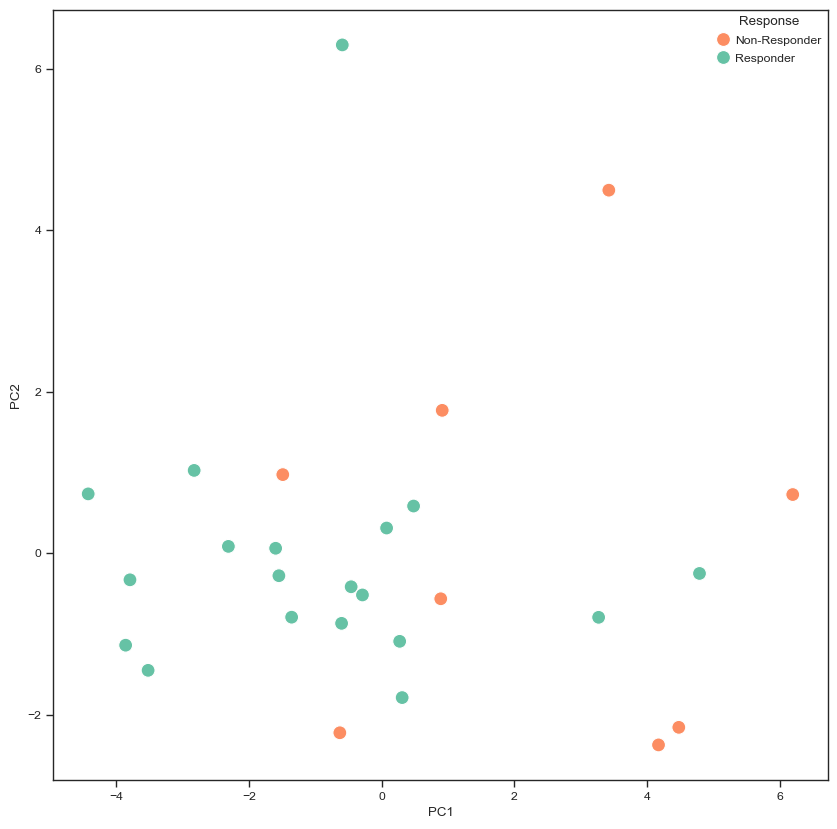

In [ ]:
# global PCA plot
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(exp_matrix_avg.T)
pca_df = pd.DataFrame(pca_coords, index=exp_matrix_avg.columns, columns=["PC1", "PC2"])
pca_df["Response"] = meta["Response"]

plt.figure(figsize=(10,10))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Response",
    palette=response_palette,
    s=100
)

plt.savefig(DEG_path / "global_pca.pdf", transparent=True, bbox_inches='tight', dpi=300)

<h1><b>High-Tumour DEG Analysis

In [ ]:
htdata = dc.pp.pseudobulk(adata_hightumour, sample_col="Melpin", groups_col="new_specific_labels", layer="counts", mode="sum")
dc.pp.filter_samples(htdata, inplace=True)
htdata

htdata.layers["counts"] = htdata.X.copy()

sc.pp.normalize_total(htdata, target_sum=1e4)
sc.pp.log1p(htdata)
sc.pp.scale(htdata, max_value=10)
sc.pp.pca(htdata)

# return raw counts to X
dc.pp.swap_layer(htdata, "counts", inplace=True)

ht_pds2 = pt.tl.PyDESeq2(adata=htdata, design="~Response")
ht_pds2.fit()

ht_df = ht_pds2.test_contrasts(ht_pds2.contrast(column="Response", baseline="Non-Responder", group_to_compare="Responder"))
ht_df.head(10)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.12 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...


Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_id                                                                   
NOTCH3      44.060307        0.868437  0.273120  3.179685  1.474351e-03   
HLA-B      287.052416        1.075109  0.149221  7.204808  5.812555e-13   
IL4          0.955086       -1.169717  0.260047 -4.498101  6.856323e-06   
AREG         2.171676       -0.562206  0.260137 -2.161189  3.068077e-02   
CTSW         7.499721        0.828350  0.293415  2.823130  4.755728e-03   
...               ...             ...       ...       ...           ...   
TNFRSF13C   11.170709       -0.122080  0.224752 -0.543176  5.870084e-01   
CLEC14A     16.239464        0.119299  0.366153  0.325816  7.445633e-01   
CD79A        7.050633        1.578665  0.346276  4.558978  5.140303e-06   
IFI35       32.999589        0.634121  0.101959  6.219400  4.990591e-10   
VEGFA       76.407438       -0.724740

... done in 0.07 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 49 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 0.04 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,EPCAM,4.013095,-2.539175,0.231261,-10.979700,4.785090e-28,2.296843e-25,None
1,PDGFRA,41.886356,-2.760674,0.287274,-9.609916,7.260828e-22,1.195034e-19,None
2,CCL16,4.770812,-2.331716,0.242710,-9.607005,7.468962e-22,1.195034e-19,None
3,SLC7A11,19.665077,-2.645458,0.305885,-8.648552,5.215679e-18,6.258815e-16,None
4,IL2,4.201810,-1.914083,0.241315,-7.931903,2.158131e-15,2.071805e-13,None
5,KLRF1,6.828150,-1.607328,0.208902,-7.694170,1.424156e-14,1.139325e-12,None
6,SLC1A5,158.190049,-1.441691,0.188690,-7.640530,2.163295e-14,1.317890e-12,None
7,PPAT,13.146582,-1.014173,0.132770,-7.638570,2.196483e-14,1.317890e-12,None
8,CD36,35.345762,-2.242503,0.297330,-7.542128,4.623644e-14,2.430245e-12,None
9,MX1,78.744378,1.506574,0.200069,7.530284,5.063011e-14,2.430245e-12,None


2025-10-29 17:39:15 | [INFO] maxp pruned
2025-10-29 17:39:15 | [INFO] LTSH dropped
2025-10-29 17:39:15 | [INFO] cmap pruned
2025-10-29 17:39:15 | [INFO] kern dropped
2025-10-29 17:39:15 | [INFO] post pruned
2025-10-29 17:39:15 | [INFO] PCLT dropped
2025-10-29 17:39:15 | [INFO] JSTF dropped
2025-10-29 17:39:15 | [INFO] DSIG dropped
2025-10-29 17:39:15 | [INFO] GPOS pruned
2025-10-29 17:39:15 | [INFO] GSUB pruned
2025-10-29 17:39:15 | [INFO] glyf pruned
2025-10-29 17:39:15 | [INFO] Added gid0 to subset
2025-10-29 17:39:15 | [INFO] Added first four glyphs to subset
2025-10-29 17:39:15 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-10-29 17:39:15 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'X', 'eight', 'five', 'hyphen', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two']
2025-10-29 17:39:15 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 22, 24, 25, 26, 27, 28, 3

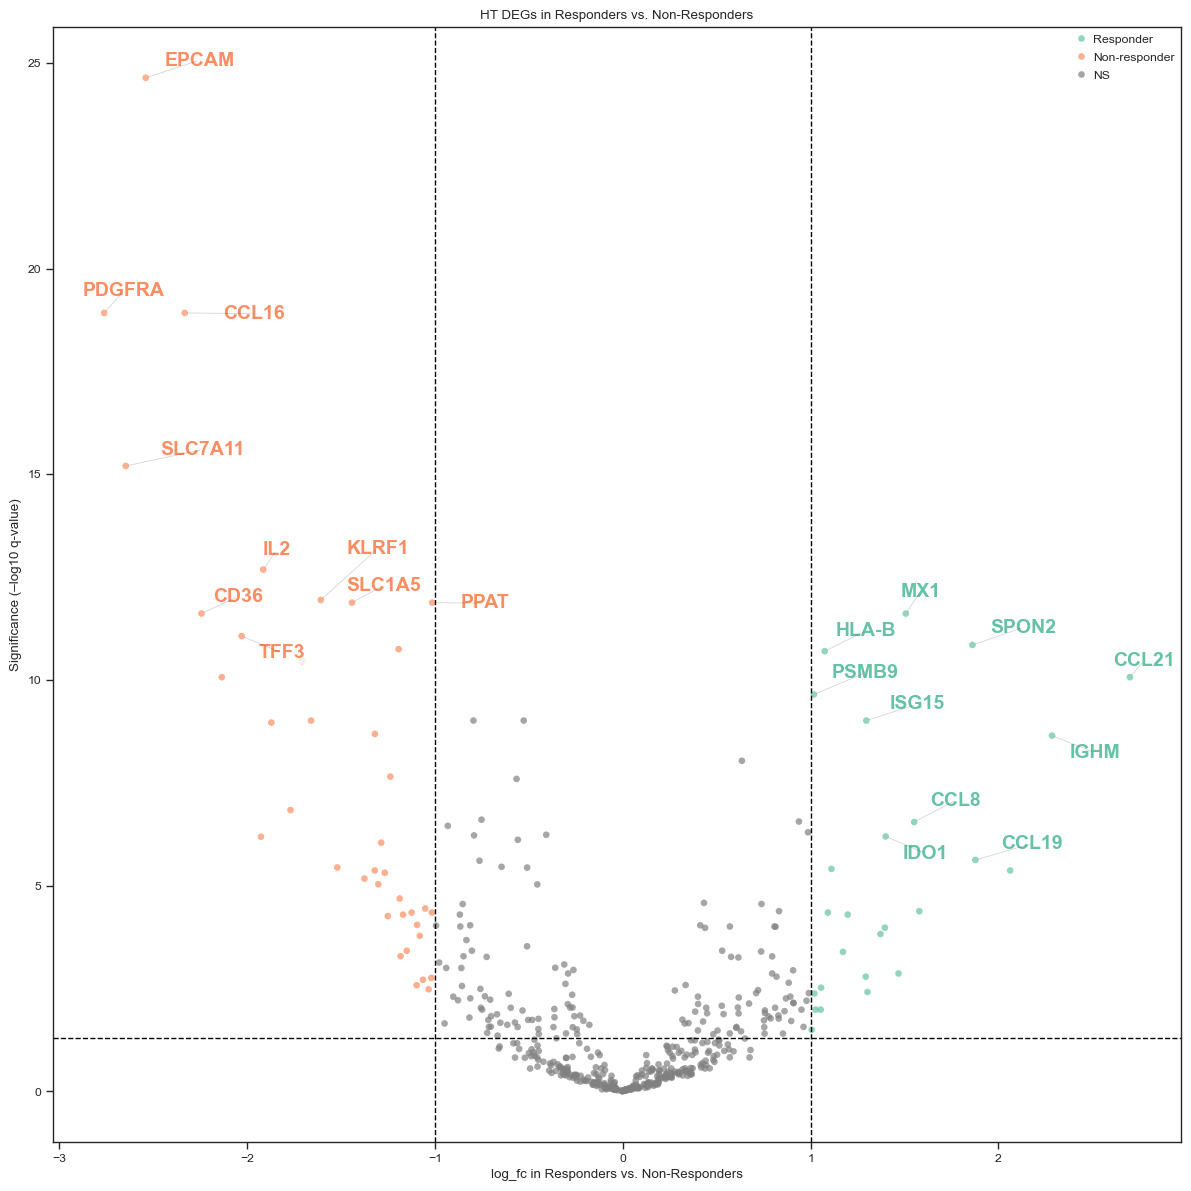

In [ ]:
df = ht_df.copy()
df.replace(0.0, 1e-323)


adj_p_value_max = 0.05            # q-value < 0.05
lfc_min = 1             # lfc < 1

df['-log10(adj_p_value)'] = -np.log10(df['adj_p_value'])  # -log10(q) so a smaller (more significant) q-values have points higher on the y-axis

def label(row):
    if row['adj_p_value'] < adj_p_value_max and row['log_fc'] > lfc_min:
        return 'Responder'
    elif row['adj_p_value'] < adj_p_value_max and row['log_fc'] < -lfc_min:
        return 'Non-responder'
    else:
        return 'NS'
df['enriched_in'] = df.apply(label, axis=1)

lfc_cap = 20
df["log_fc_capped"] = df["log_fc"].clip(-lfc_cap, lfc_cap)

plt.figure(figsize=(12,12))
sns.scatterplot(
    data=df, x="log_fc_capped", y="-log10(adj_p_value)",
    hue="enriched_in", hue_order=["Responder", "Non-responder", "NS"],
    palette={"Responder":"#66c2a5", "Non-responder":"#fc8d62", "NS":"grey"},
    alpha=0.7, edgecolor="none"
)

# threshold lines
plt.axhline(-np.log10(adj_p_value_max), color="black", linestyle="--", linewidth=1)
plt.axvline(lfc_min, color="black", linestyle="--", linewidth=1)
plt.axvline(-lfc_min, color="black", linestyle="--", linewidth=1)

# top 10 DEGs in R and NR
top_responder = df[
    (df['enriched_in'] == "Responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)
top_nonresponder = df[
    (df['enriched_in'] == "Non-responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)

# label top 10 DEGs
texts = []
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#66c2a5",  # same color as responders
        ha='left', va='baseline',
        weight='bold',
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
    )
    for _, row in top_responder.iterrows()
)
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#fc8d62",  # same color as non-responders
        weight='bold',
        ha='left', va='baseline',
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=1.5)
    )
    for _, row in top_nonresponder.iterrows()
)
# adjust labels to avoid overlaps
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5, alpha=0.2),
            force_points=3.5, expand=(1.5, 1.5))

plt.xlabel("log_fc in Responders vs. Non-Responders")
plt.ylabel("Significance (–log10 q-value)")
plt.title("HT DEGs in Responders vs. Non-Responders")
plt.legend()
plt.tight_layout()
plt.savefig(DEG_path / 'ht_volcano.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# export DEGs for fgsea
ht_df.to_csv(DEG_path / 'ht_DEG.csv', index=False)

<h1><b>Peritumour DEG Analysis

In [ ]:
peridata = dc.pp.pseudobulk(adata_peritumour, sample_col="Melpin", groups_col="new_specific_labels", layer="counts", mode="sum")
dc.pp.filter_samples(peridata, inplace=True)

peridata.layers["counts"] = peridata.X.copy()

sc.pp.normalize_total(peridata, target_sum=1e4)
sc.pp.log1p(peridata)
sc.pp.scale(peridata, max_value=10)
sc.pp.pca(peridata)

# return raw counts to X
dc.pp.swap_layer(peridata, "counts", inplace=True)

p_pds2 = pt.tl.PyDESeq2(adata=peridata, design="~Response")
p_pds2.fit()

p_df = p_pds2.test_contrasts(p_pds2.contrast(column="Response", baseline="Non-Responder", group_to_compare="Responder"))
p_df.head(10)

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.11 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.10 seconds.

Fitting LFCs...


Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_id                                                                   
NOTCH3      33.525256        0.306137  0.291020  1.051943  2.928255e-01   
HLA-B      194.893381        0.596438  0.137082  4.350959  1.355431e-05   
IL4          0.646236       -0.703362  0.279458 -2.516882  1.183983e-02   
AREG         2.770012       -0.796718  0.324274 -2.456929  1.401303e-02   
CTSW         5.844530        1.030111  0.308810  3.335748  8.507027e-04   
...               ...             ...       ...       ...           ...   
TNFRSF13C   13.129227        1.162212  0.278617  4.171366  3.027792e-05   
CLEC14A      9.831595        1.050685  0.399842  2.627749  8.595202e-03   
CD79A       10.053696        2.348513  0.394480  5.953435  2.625723e-09   
IFI35       22.612404        0.783677  0.117963  6.643418  3.064902e-11   
VEGFA       65.539428       -0.621960

... done in 0.08 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 52 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 0.03 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,EPCAM,5.049906,-3.842343,0.285072,-13.478516,2.092736e-41,8.620293e-39,None
1,IGHG4,66.255811,5.434595,0.404402,13.438598,3.591789e-41,8.620293e-39,None
2,IGHG2,69.119033,5.341275,0.424128,12.593545,2.291460e-36,3.666336e-34,None
3,IGHG1,195.087890,3.776198,0.357059,10.575826,3.857617e-26,4.629141e-24,None
4,IGHGP,174.129899,4.251868,0.412699,10.302593,6.858749e-25,6.584399e-23,None
5,PDGFRA,65.535887,-3.061869,0.317072,-9.656708,4.604237e-22,3.683390e-20,None
6,TLK2,50.147966,-0.778505,0.084301,-9.234821,2.587181e-20,1.774067e-18,None
7,IGHG3,72.517903,3.159030,0.361429,8.740377,2.323329e-18,1.393998e-16,None
8,IRF1,48.085874,1.419327,0.175334,8.094974,5.727656e-16,3.054750e-14,None
9,LIF,23.319784,2.229139,0.306718,7.267710,3.656321e-13,1.755034e-11,None


2025-10-29 17:39:38 | [INFO] maxp pruned
2025-10-29 17:39:38 | [INFO] LTSH dropped
2025-10-29 17:39:38 | [INFO] cmap pruned
2025-10-29 17:39:38 | [INFO] kern dropped
2025-10-29 17:39:38 | [INFO] post pruned
2025-10-29 17:39:38 | [INFO] PCLT dropped
2025-10-29 17:39:38 | [INFO] JSTF dropped
2025-10-29 17:39:38 | [INFO] DSIG dropped
2025-10-29 17:39:38 | [INFO] GPOS pruned
2025-10-29 17:39:38 | [INFO] GSUB pruned
2025-10-29 17:39:38 | [INFO] glyf pruned
2025-10-29 17:39:38 | [INFO] Added gid0 to subset
2025-10-29 17:39:38 | [INFO] Added first four glyphs to subset
2025-10-29 17:39:38 | [INFO] Closing glyph list over 'GSUB': 28 glyphs before
2025-10-29 17:39:38 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 'three', 'two']
2025-10-29 17:39:38 | [INFO] Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 23, 24, 26, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4

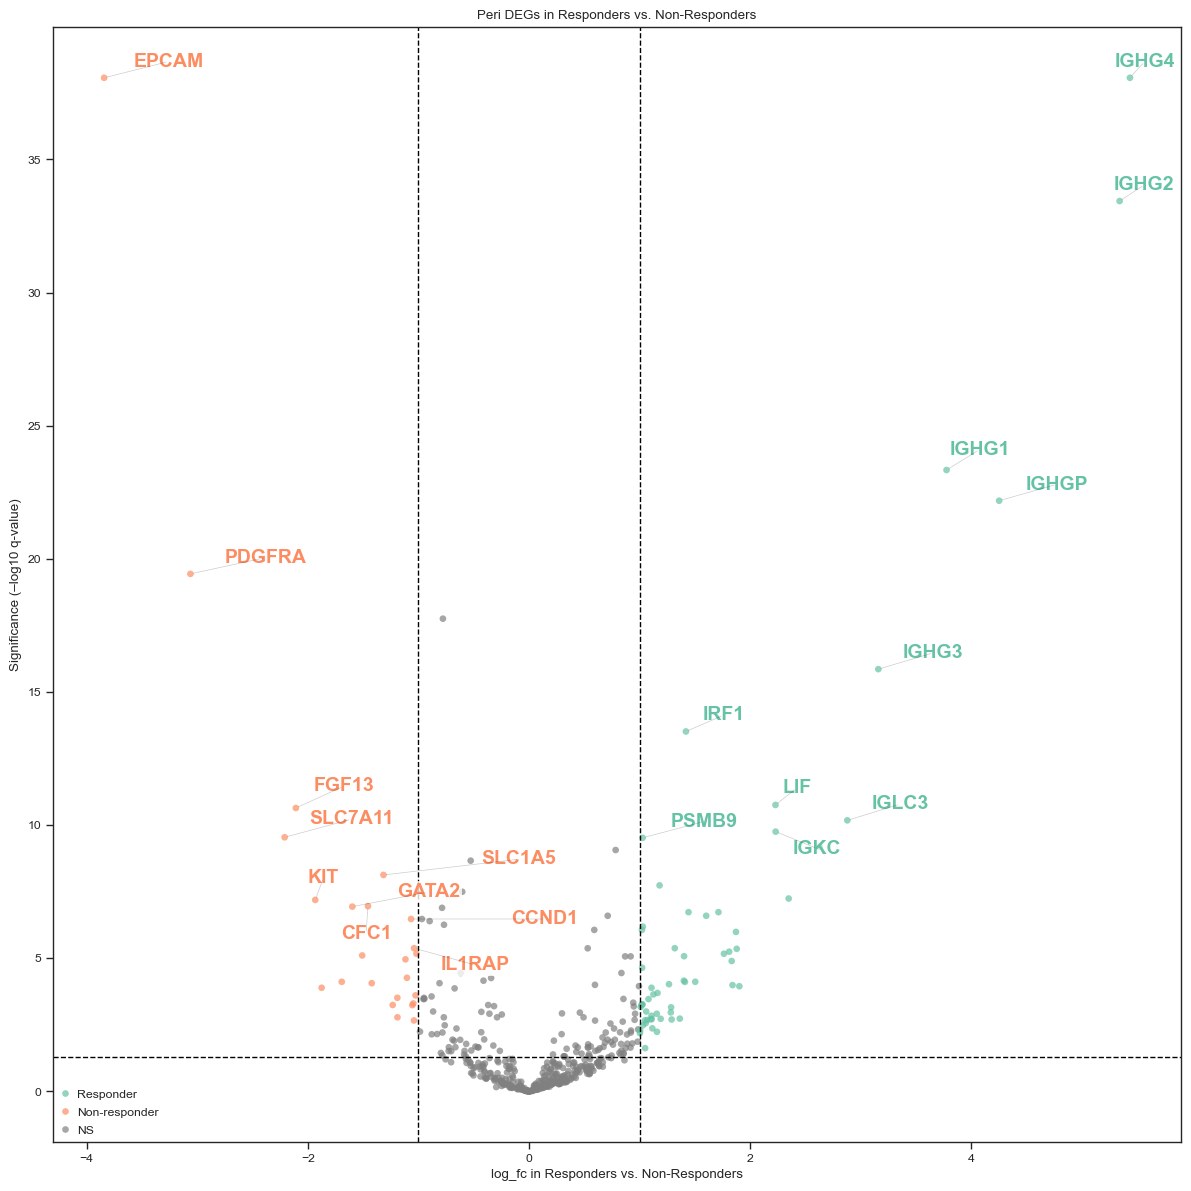

In [ ]:
df = p_df.copy()
df.replace(0.0, 1e-323)

# set thresholds
adj_p_value_max = 0.05            # q-value < 0.05
lfc_min = 1                       # lfc < 1

df['-log10(adj_p_value)'] = -np.log10(df['adj_p_value'])  # -log10(q) so a smaller (more significant) q-values have points higher on the y-axis

def label(row):
    if row['adj_p_value'] < adj_p_value_max and row['log_fc'] > lfc_min:
        return 'Responder'
    elif row['adj_p_value'] < adj_p_value_max and row['log_fc'] < -lfc_min:
        return 'Non-responder'
    else:
        return 'NS'
df['enriched_in'] = df.apply(label, axis=1)

lfc_cap = 20 
df["log_fc_capped"] = df["log_fc"].clip(-lfc_cap, lfc_cap)

# volcano plot
plt.figure(figsize=(12,12))
sns.scatterplot(
    data=df, x="log_fc_capped", y="-log10(adj_p_value)",
    hue="enriched_in", hue_order=["Responder", "Non-responder", "NS"],
    palette={"Responder":"#66c2a5", "Non-responder":"#fc8d62" , "NS":"grey"},
    alpha=0.7, edgecolor="none"
)

# threshold lines
plt.axhline(-np.log10(adj_p_value_max), color="black", linestyle="--", linewidth=1)
plt.axvline(lfc_min, color="black", linestyle="--", linewidth=1)
plt.axvline(-lfc_min, color="black", linestyle="--", linewidth=1)

# top 10 DEGs in R and NR
top_responder = df[
    (df['enriched_in'] == "Responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)
top_nonresponder = df[
    (df['enriched_in'] == "Non-responder") & df['-log10(adj_p_value)']
    .replace([np.inf, -np.inf], np.nan).notna()].sort_values("adj_p_value", ascending=True).drop_duplicates("variable").head(10)

# label top 10 DEGs
texts = []
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#66c2a5",  # same color as responders
        ha='left', va='baseline',
        weight='bold',
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
    )
    for _, row in top_responder.iterrows()
)
texts.extend(
    plt.text(
        row["log_fc_capped"],
        row["-log10(adj_p_value)"],
        row["variable"],
        fontsize=14,
        color="#fc8d62",  # same color as non-responders
        weight='bold',
        ha='left', va='baseline',
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=1.5)
    )
    for _, row in top_nonresponder.iterrows()
)
# adjust labels to avoid overlaps
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5, alpha=0.2),
            force_points=3.5, expand=(1.5, 1.5))

plt.xlabel("log_fc in Responders vs. Non-Responders")
plt.ylabel("Significance (–log10 q-value)")
plt.title("Peri DEGs in Responders vs. Non-Responders")
plt.legend()
plt.tight_layout()
plt.savefig(DEG_path / 'peri_volcano.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# export DEG list for fgsea
p_df.to_csv(DEG_path / 'peri_DEG.csv', index=False)